In [1]:
#|default_exp sgd

In [115]:
#|export 
import torch
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [2]:
from functools import partial 

import torch
from torch import nn, optim, tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torcheval.metrics import MulticlassAccuracy

from datasets import load_dataset
import matplotlib.pyplot as plt

import fastcore.all as fc

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(42)
plt.style.use('fast')
import logging; logging.disable(logging.WARNING)

In [4]:
name = "fashion_mnist"
dsd = load_dataset(name)
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
xl, yl = 'image', 'label'

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=512, num_workers=4)

tensor(5)

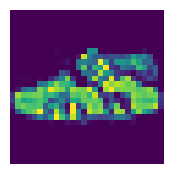

In [6]:
xb, yb = next(iter(dls.train))
show_image(xb[0], figsize=(2,2));
yb[0]

# L2 Regularization

$$L(w) \quad += \sum_i w_i^2$$
$$\frac{\delta L(w)}{\delta w} \quad += \sum_i 2w_i $$

In [7]:
class SGD:
    def __init__(self, parameters, lr, wd=0.01): 
        self.parameters = list(parameters)
        self.lr = lr
        self.wd = wd
        self.i = 1
        
    def step(self): 
        with torch.no_grad():
            for p in self.parameters:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def reg_step(self, p): # L2 Reg, equiv to weight decay
        p *= (1 - self.lr * self.wd) 
            
    def opt_step(self, p):
        p -= self.lr * p.grad           
            
    def zero_grad(self): 
        for p in self.parameters:
            p.grad.data.zero_()

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(mod_filter=fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)

accuracy,loss,epoch,train
0.794,0.595,0,train
0.754,0.739,0,eval
0.828,0.500,1,train
0.621,1.140,1,eval
0.827,0.497,2,train
0.740,0.744,2,eval


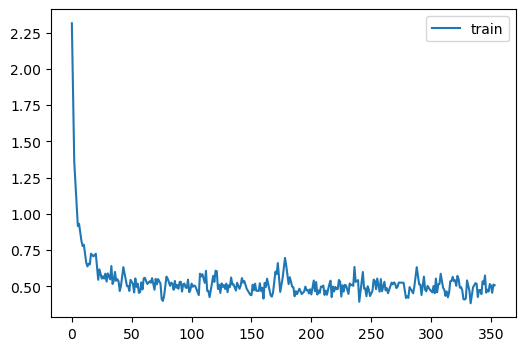

In [18]:
learn = Learner(model, dls, F.cross_entropy, lr=1, cbs=cbs, opt_func=SGD)
learn.fit(3)

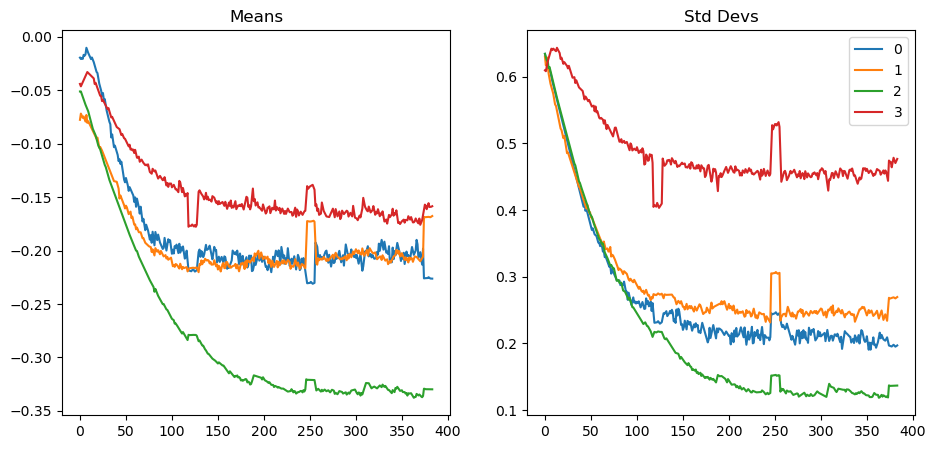

In [19]:
astats.plot_stats()

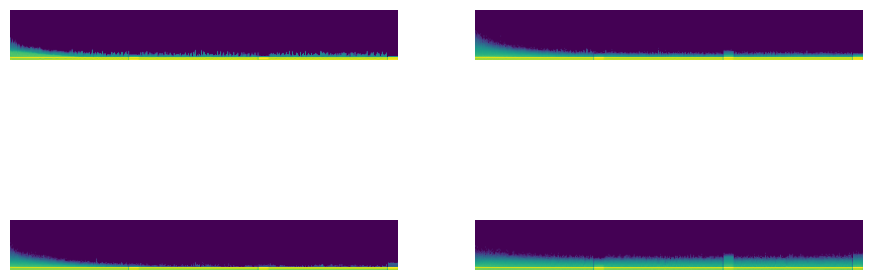

In [20]:
astats.color_dim()

## Momentum

In [21]:
def f(x):
    return -x**2 + 3*x

xs = torch.linspace(-4, 4, 100)
ys = f(xs) + torch.rand_like(xs)*6-3

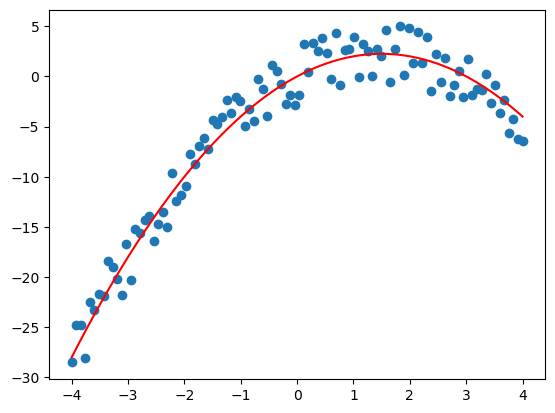

In [22]:
plt.scatter(xs, ys)
plt.plot(xs, f(xs), color='r')

In [24]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(beta=widgets.FloatSlider(min=0, max=1-1e-10, value=0.5, step=0.001))
def plot_momentum(beta):
    zs = []
    avg = ys[0]
    for y in ys:
        avg = beta*avg + (1-beta)*y
        zs.append(avg)

    plt.scatter(xs, ys)
    plt.plot(xs, zs, color='red');

interactive(children=(FloatSlider(value=0.5, description='beta', max=0.9999999999, step=0.001), Output()), _do…

In [9]:
from IPython.core.debugger import set_trace

class Momentum(SGD):
    def __init__(self, parameters, lr, mom=0.9, wd=0.): 
        super().__init__(parameters, lr=lr, wd=wd)
        self.mom = mom


    def opt_step(self, p): 
        if not hasattr(p, 'grad_avg'): p.grad_avg = p.grad.detach() # Clone the gradients
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1 - self.mom)        
        p -= self.lr*p.grad_avg
        

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(mod_filter=fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)

accuracy,loss,epoch,train
0.794,0.566,0,train
0.839,0.448,0,eval
0.862,0.377,1,train
0.852,0.402,1,eval
0.873,0.343,2,train
0.862,0.377,2,eval


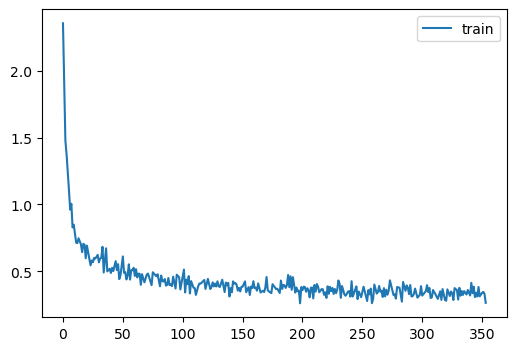

In [27]:
set_seed(42)
learn = Learner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)
learn.fit(3)

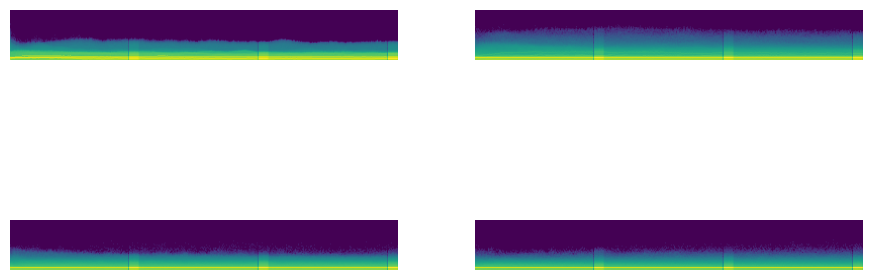

In [28]:
astats.color_dim()

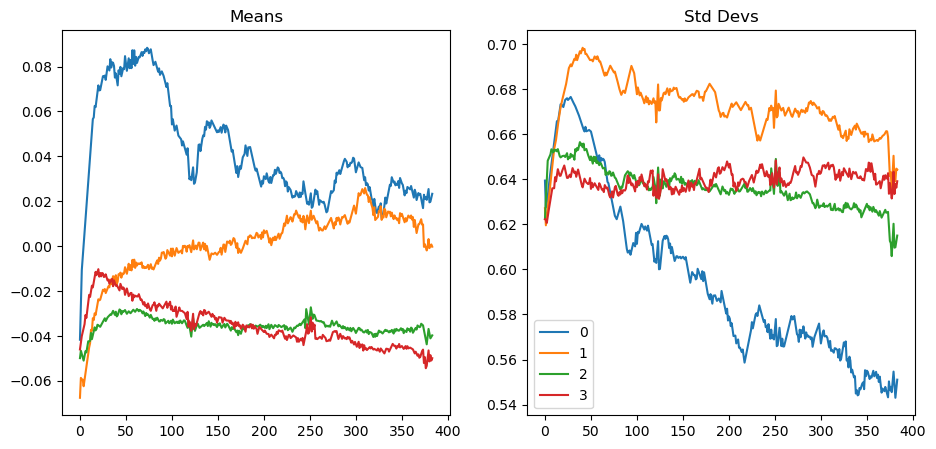

In [29]:
 astats.plot_stats()

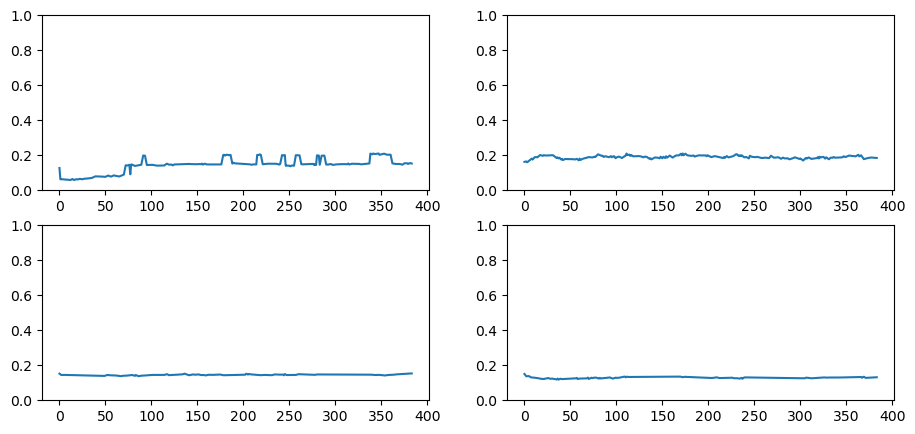

In [30]:
astats.dead_chart()

## RMSProp

We keep record of the moving average of the squares of the gradients for each parameter. If we assume that the gradients have 0 mean, then the mean of the squares is the variance. Thus this moving average somewhat estimates the variance (kinda, Adam does it better). We can try to ensure that our updates have always variance 1, that is, we divide by sqrt of our moving average.

In [11]:
class RMSProp(SGD):
    def __init__(self, parameters, lr, mom=0.99, wd=0., eps=1e-5): 
        super().__init__(parameters, lr=lr, wd=wd)
        self.mom = mom
        self.eps = eps


    def opt_step(self, p): 
        if not hasattr(p, 'sqr_grad_avg'): p.sqr_grad_avg = p.grad.detach()**2 # Clone the gradients
        p.sqr_grad_avg = p.sqr_grad_avg*self.mom + p.grad**2 *(1 - self.mom)        
        upd = p.grad / (p.sqr_grad_avg.sqrt() + self.eps)
        p -= self.lr*upd
        

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(mod_filter=fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)

accuracy,loss,epoch,train
0.807,0.558,0,train
0.800,0.548,0,eval
0.862,0.372,1,train
0.793,0.557,1,eval
0.874,0.338,2,train
0.811,0.493,2,eval


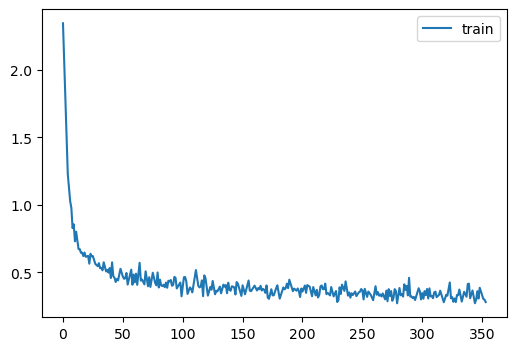

In [33]:
learn = Learner(model, dls, F.cross_entropy, lr=5e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

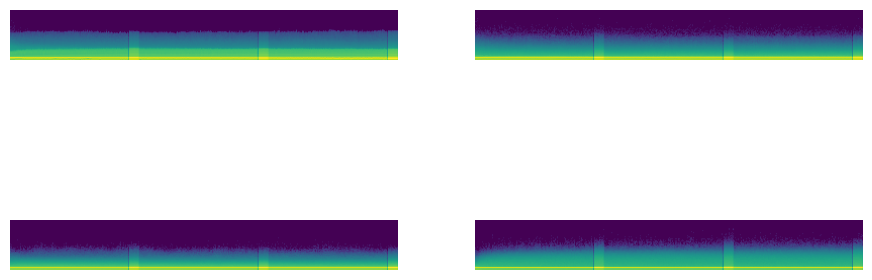

In [34]:
astats.color_dim()

# Adam

Let's keep a moving average of the mean and variance of the gradients. We'll correct our updates to use the accumulated mean, but corrected to have variance 1.

In [13]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta_1=0.9, beta_2=0.99, eps=1e-5):
        super().__init__(params, lr, wd)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        if not hasattr(p, 'grad_sqr_avg'): p.grad_sqr_avg = torch.zeros_like(p.grad)

        # We need to unbias the moving averages due to init with zeros
        p.grad_avg     = p.grad_avg*self.beta_1 + p.grad*(1 - self.beta_1) 
        p.grad_sqr_avg = p.grad_sqr_avg*self.beta_2 + p.grad**2*(1 - self.beta_2)
        
        unb_avg     = p.grad_avg / (1 - self.beta_1**self.i)
        unb_sqr_avg = p.grad_sqr_avg / (1 - self.beta_2**self.i)
        
        upd = unb_avg / (unb_sqr_avg.sqrt() + self.eps)
        p -= self.lr*upd

In [14]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(mod_filter=fc.risinstance(GeneralReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, astats]
act_gr = partial(GeneralReLU, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)

accuracy,loss,epoch,train
0.809,0.561,0,train
0.849,0.409,0,eval
0.870,0.353,1,train
0.850,0.403,1,eval
0.882,0.321,2,train
0.871,0.363,2,eval


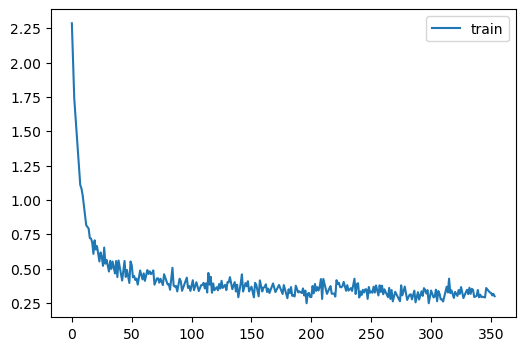

In [37]:
learn = Learner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

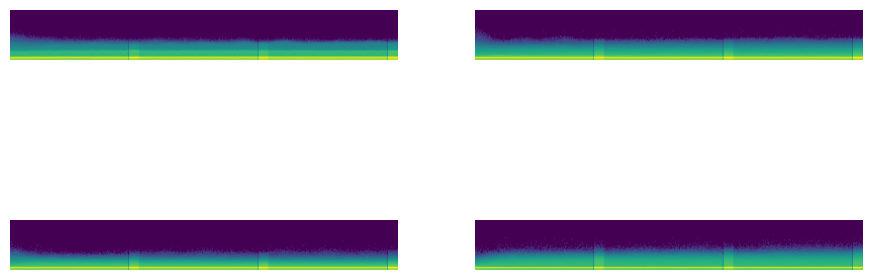

In [38]:
astats.color_dim()

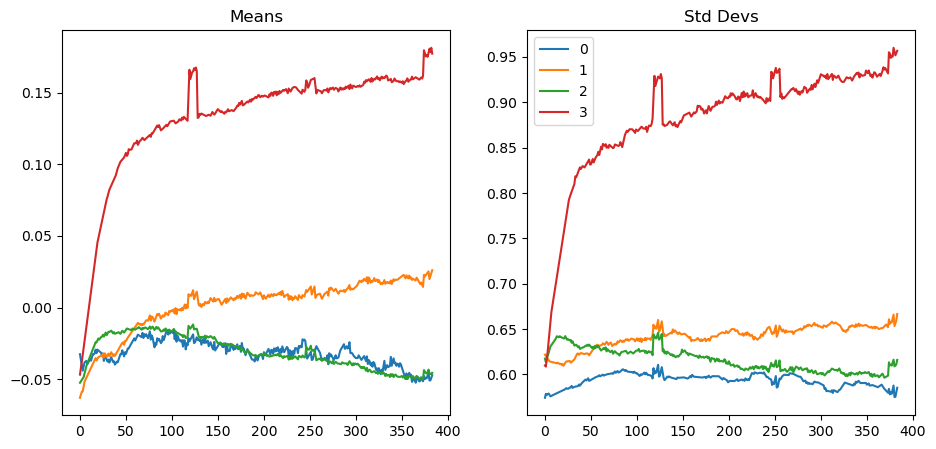

In [39]:
astats.plot_stats()

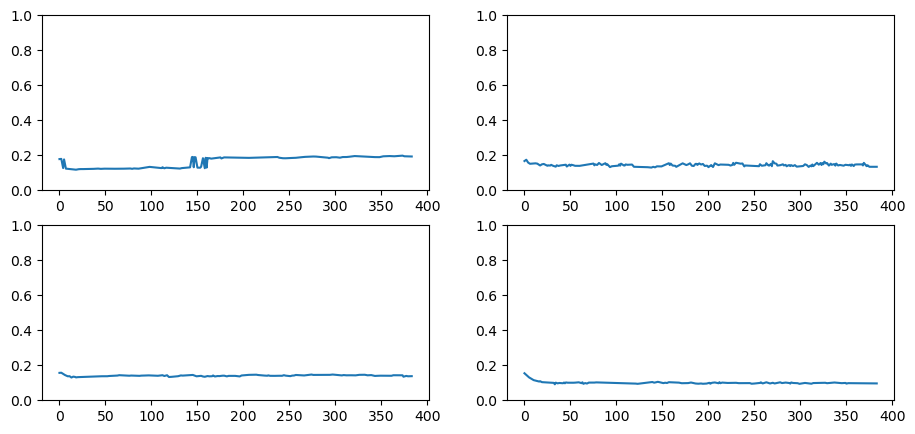

In [40]:
astats.dead_chart()

## Schedulers

Adjust LR using a callback

In [15]:
from torch.optim import lr_scheduler

In [16]:
print('\n'.join([o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower()]))

ChainedScheduler
ConstantLR
CosineAnnealingLR
CosineAnnealingWarmRestarts
Counter
CyclicLR
ExponentialLR
LambdaLR
LinearLR
MultiStepLR
MultiplicativeLR
OneCycleLR
Optimizer
PolynomialLR
ReduceLROnPlateau
SequentialLR
StepLR


In [72]:
learn = Learner(get_model(act_gr), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()], opt_func=optim.AdamW)
learn.fit(2)

Stopping at epoch 1


In [73]:
opt = learn.opt
opt

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.006
    maximize: False
    weight_decay: 0.01
)

In [74]:
print('\n'.join(o for o in dir(opt) if o[0] != '_'))

add_param_group
defaults
load_state_dict
param_groups
state
state_dict
step
zero_grad


In [76]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [77]:
len(opt.param_groups)

1

In [78]:
pg = opt.param_groups[0]
list(pg)

['params',
 'lr',
 'betas',
 'eps',
 'weight_decay',
 'amsgrad',
 'foreach',
 'maximize',
 'capturable']

In [79]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)
sched.base_lrs

[0.006]

In [80]:
sched.get_last_lr()

[0.006]

In [81]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

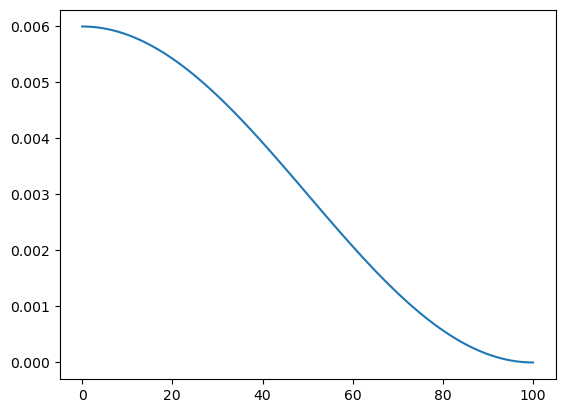

In [82]:
sched_lrs(sched, 100)

## Scheduler Callbacks

In [85]:
#| export
class BaseSchedulerCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn: Learner): self.sched_opt = self.sched(learn.opt)
    def _step(self, learn: Learner): 
        if learn.training:
            self.sched_opt.step()

In [86]:
#| export
class BatchSchedCB(BaseSchedulerCB):
    def after_batch(self, learn): self._step(learn)

In [87]:
#| export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn: Learner):
        self.recs = {k: [] for k in self.d}
        self.pg = learn.opt.param_groups[0]
        
    def after_batch(self, learn: Learner):
        if not learn.training: return
        for k, v in self.d.items():
            self.recs[k].append(v(self))
            
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [88]:
def _lr(cb): return cb.pg['lr']

In [89]:
len(dls.train)

118

In [90]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.824,0.494,0,train
0.845,0.424,0,eval
0.874,0.339,1,train
0.871,0.344,1,eval
0.891,0.292,2,train
0.877,0.333,2,eval


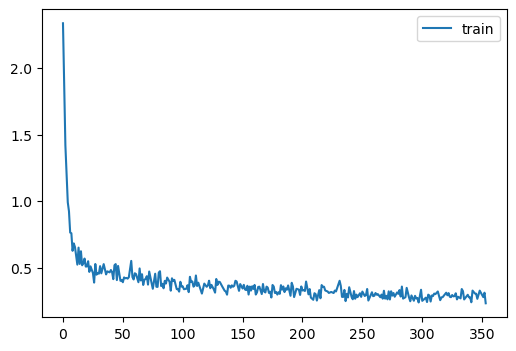

In [91]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
learn = Learner(model, dls, F.cross_entropy, lr=2e-2, 
                cbs=[DeviceCB(), ProgressCB(plot=True), 
                     metrics, astats, BatchSchedCB(sched), rec],
                opt_func=optim.AdamW)
learn.fit(3)

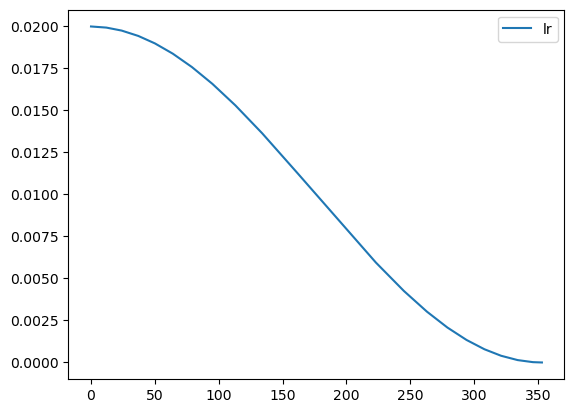

In [61]:
rec.plot()

In [92]:
#| export
class EpochSchedulerCB(BaseSchedulerCB):
    def after_epoch(self, learn: Learner): self._step(learn)

accuracy,loss,epoch,train
0.823,0.489,0,train
0.837,0.441,0,eval
0.869,0.352,1,train
0.861,0.380,1,eval
0.881,0.322,2,train
0.871,0.354,2,eval


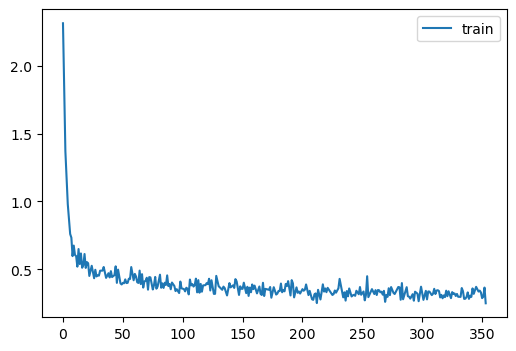

In [93]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
learn = Learner(model, dls, F.cross_entropy, lr=2e-2, 
                cbs=[DeviceCB(), ProgressCB(plot=True), 
                     metrics, astats, EpochSchedulerCB(sched), rec],
                opt_func=optim.AdamW)
learn.fit(3) 

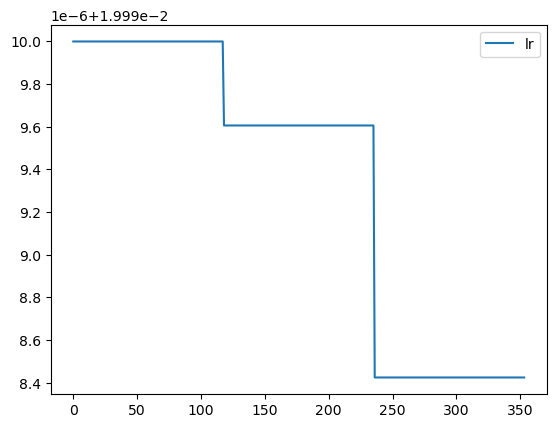

In [94]:
rec.plot()

# 1Cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith

In [95]:
def _beta1(cb): return cb.pg['betas'][0]
def _beta2(cb): return cb.pg['betas'][1]

rec = RecorderCB(lr=_lr, mom=_beta1, var=_beta2)

accuracy,loss,epoch,train
0.795,0.608,0,train
0.816,0.566,0,eval
0.856,0.393,1,train
0.843,0.453,1,eval
0.872,0.345,2,train
0.867,0.373,2,eval
0.890,0.294,3,train
0.884,0.319,3,eval
0.906,0.248,4,train
0.892,0.296,4,eval


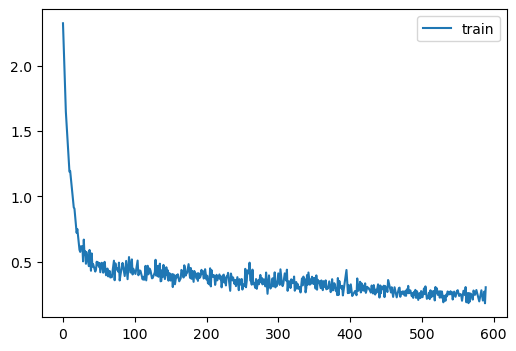

In [113]:
set_seed(1)
lr, epochs = 0.1, 5
model = get_model(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=[
    DeviceCB(), metrics, astats, ProgressCB(plot=True),
    BatchSchedCB(sched), rec], opt_func=optim.AdamW)
learn.fit(epochs)

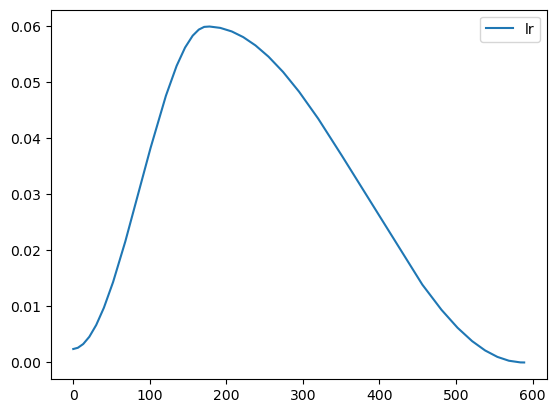

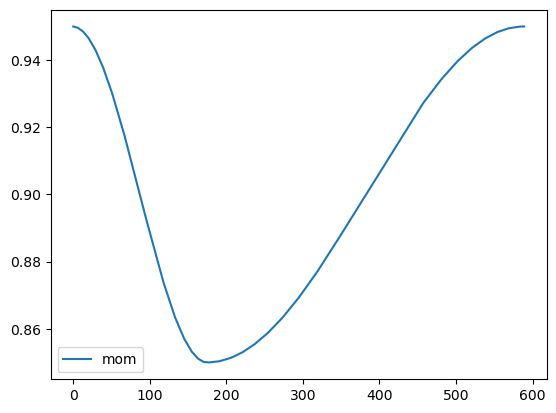

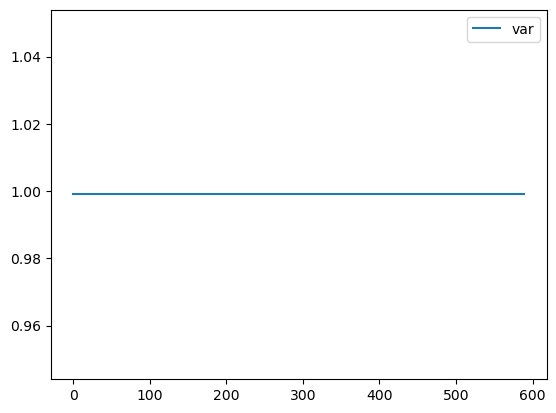

In [97]:
rec.plot()

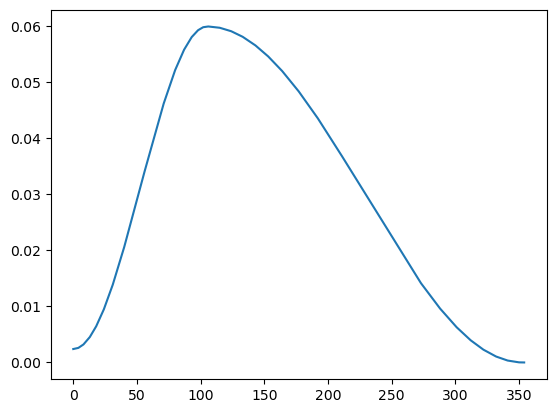

In [110]:
sched_lrs(lr_scheduler.OneCycleLR(learn.opt, max_lr=lr, total_steps=len(dls.train) * 3), len(dls.train)*3)

In [116]:
import nbdev; nbdev.nbdev_export()